# Benchmark com Microsoft GrabCut (50 imagens)

Utilizando a métrica _error rate_, esse notebook propõe-se construir uma avaliação no dataset grabcut para avaliar a taxa de erro médio para o algoritmo EGSIS. A intenção é realizar uma comparação com as técnicas avaliadas no artigo _Segmentation by t

O. Duchenne, J. -Y. Audibert, R. Keriven, J. Ponce and F. Segonne, "Segmentation by transduction," 2008 IEEE Conference on Computer Vision and Pattern Recognition, Anchorage, AK, USA, 2008, pp. 1-8, doi: 10.1109/CVPR.2008.4587419.

In [1]:
from egsis.datasets import grabcut
import matplotlib.pyplot as plt
from egsis import model
from egsis import metrics

# Avaliação única aleatória

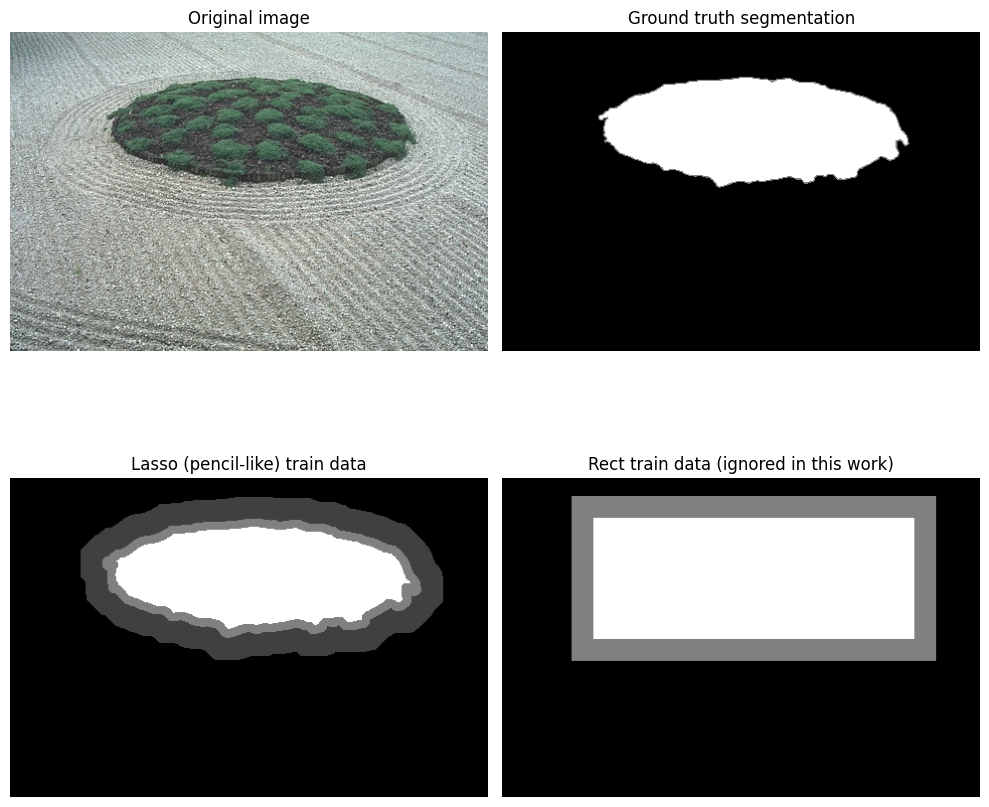

In [2]:
img = grabcut.get_random_image()
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(img.data)
ax[0, 0].set_title("Original image")
ax[0, 1].imshow(img.segmentation, cmap="gray")
ax[0, 1].set_title("Ground truth segmentation")
ax[1, 0].imshow(img.lasso, cmap="gray")
ax[1, 0].set_title("Lasso (pencil-like) train data")
ax[1, 1].imshow(img.rect, cmap="gray")
ax[1, 1].set_title("Rect train data (ignored in this work)")


for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

# Labelling description 

**Segmentation**: A tri-map which specifies background (0), foreground (255) and
mixed area (128). The mixed area contains pixels which are a combination of foreand background texture. Note, in low contrast regions the true boundary is not
observed and the ground truth is in this case a "good guess".

**Labelling-Lasso**: Imitates a tri-map obtained by a lasso or pen tool. The colour
coding is: 

- background (0);
- background - used for colour model training (64);
- inference (unknown) region (128);
- foreground - used for colour model training (255).

Note, a lasso tool can be imitated by specifying the foreground region (255) as unknown
(128).

**Labelling-Rectangle**: Imitates a tri-map obtained by two mouse clicks (rectangle).
Same colour coding as in Labelling-Lasso.

In [3]:
# Preprocessing labeling scheme
# y_train = img.lasso
# y_train[y_train == 64] = 1 # background
# y_train[y_train == 128] = 0 # means unlabelled for egsis
# y_train[y_train == 255] = 2 # foreground
# y_true = img.segmentation
# y_true[y_true == 128] = 1
# y_true[y_true == 255] = 1

# not more necessary the steps above, replaced by:
y_train = img.y_train()
y_true = img.y_true()

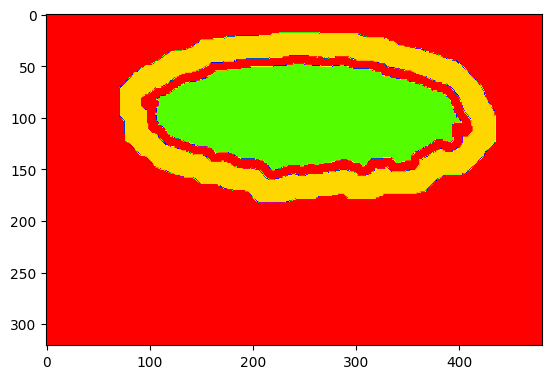

In [4]:
plt.imshow(y_train, cmap="prism")  

# the green region it's training data for background
# the yellow region it's training data for foreground

2023-11-11 00:04:47.304 | INFO     | egsis.model:fit_predict:142 - Run!
2023-11-11 00:04:50.655 | INFO     | egsis.lcu:__init__:90 - hyperparams: n_classes=2, competition_level=1, max_iter=100
2023-11-11 00:04:50.655 | DEBUG    | egsis.lcu:n0:222 - n0: classes=2, shape=(2, 40)
2023-11-11 00:04:50.657 | INFO     | egsis.lcu:n0:229 - n0: [[0.         2.10526316 2.10526316 1.57894737 2.10526316 2.10526316
  2.10526316 0.         0.         0.         0.         3.15789474
  0.         3.15789474 0.         0.         0.         2.63157895
  3.15789474 0.         2.10526316 3.15789474 3.15789474 3.15789474
  3.15789474 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         6.31578947 6.31578947 7.36842105 0.
  0.         0.         7.36842105 0.         6.31578947 0.
  0.         0.         0.         0.      

(-0.5, 480.5, 320.5, -0.5)

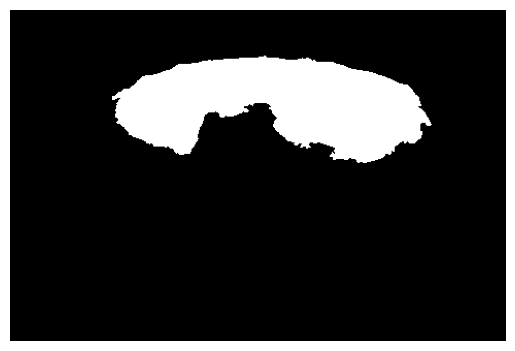

In [5]:
X = img.data
y = y_train

m = model.EGSIS(
    superpixel_segments=40,
    superpixel_sigma=0.8,
    superpixel_compactness=40,
    feature_extraction="comatrix",
    lcu_max_iter=100,
    feature_similarity="euclidian_exp",
)

# Fit predict receiving a image mask
# re-encoding y-values to be in {0,1} because for EGSIS, y=0 means non-labeled
mask = m.fit_predict_segmentation_mask(X, y) - 1
plt.imshow(mask, cmap="gray")
plt.axis('off')

In [6]:
y_train.shape

(321, 481)

In [7]:
X.shape

(321, 481, 3)

In [8]:
import numpy as np
np.unique(y_train)

array([0, 1, 2], dtype=uint8)

In [9]:
y_pred = mask
err = metrics.err(y_true, y_pred) * 100
iou = metrics.iou(y_true, y_pred)
f1 = metrics.f1(y_true, y_pred)
acc = metrics.pixel_accuracy(y_true, y_pred)
print("Segmentation Metrics!")
print(f"Err:\t{round(err, 2)}%") 
print(f"IoU:\t{round(iou, 2)}") 
print(f"F1:\t{round(f1, 2)}") 
print(f"acc:\t{round(acc, 2)}") 

Segmentation Metrics!
Err:	0.66%
IoU:	0.78
F1:	0.13
acc:	0.96


# Avaliação em Lote

In [10]:
%%time
import pandas as pd
imgs = grabcut.get_all_dataset()
stats = []
for img in imgs:
    X = img.data
    y_true = img.y_true()
    y_train = img.y_train()
    mask = m.fit_predict_segmentation_mask(X, y_train)
    # label re-encoding
    y_pred = mask - 1
    err = metrics.err(y_true, y_pred) * 100
    iou = metrics.iou(y_true, y_pred)
    f1 = metrics.f1(y_true, y_pred)
    acc = metrics.pixel_accuracy(y_true, y_pred)
    stat = [img.fname, err, iou, f1, acc]
    stats.append(stat)

df = pd.DataFrame(stats, columns=["name", "err", "iou", "f1", "acc"])
df

2023-11-11 00:04:52.143 | INFO     | egsis.model:fit_predict:142 - Run!
2023-11-11 00:04:55.766 | INFO     | egsis.lcu:__init__:90 - hyperparams: n_classes=2, competition_level=1, max_iter=100
2023-11-11 00:04:55.767 | DEBUG    | egsis.lcu:n0:222 - n0: classes=2, shape=(2, 35)
2023-11-11 00:04:55.768 | INFO     | egsis.lcu:n0:229 - n0: [[0.         2.43902439 2.43902439 0.         0.         3.65853659
  1.82926829 4.26829268 2.43902439 3.65853659 3.65853659 3.04878049
  0.         2.43902439 3.65853659 0.         4.26829268 0.
  1.82926829 1.82926829 0.         0.         0.         3.04878049
  3.04878049 0.         3.65853659 3.65853659 2.43902439 2.43902439
  3.04878049 2.43902439 0.         0.         2.43902439]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  6.09756098 0.         0.         7.31707317 0.         8.53658537
  0.         0.         7.31707317 7.31707317 4.87804878 0.
  0.         7.31707317 

CPU times: user 3min 6s, sys: 1.04 s, total: 3min 7s
Wall time: 3min 7s


,name,err,iou,f1,acc
0,memorial.jpg,8.447591,0.656026,0.134719,0.929363
1,person1.jpg,3.754878,0.853058,0.256233,0.955863
2,271008.jpg,0.318222,0.777216,0.109494,0.968614
3,sheep.jpg,0.665949,0.398664,0.022096,0.966670
4,person3.jpg,1.813834,0.612727,0.062800,0.960307
5,153093.jpg,20.244229,0.618717,0.093516,0.942371
6,banana2.bmp,6.141734,0.702828,0.183223,0.922529
7,doll.bmp,16.590308,0.851915,0.368391,0.935964
8,stone1.JPG,1.512537,0.866296,0.170902,0.973623
9,21077.jpg,11.289968,0.630992,0.082784,0.951587


In [11]:
df.describe()

,err,iou,f1,acc
count,50.000000,50.000000,50.000000,50.000000
mean,7.509637,0.655057,0.167499,0.939475
std,8.208199,0.221017,0.122231,0.026329
min,0.000000,0.000000,0.000000,0.865186
25%,0.742868,0.569530,0.076445,0.922780
50%,4.532746,0.703079,0.138337,0.945587
75%,10.864965,0.837507,0.225936,0.958284
max,28.619887,0.916648,0.506428,0.978601
